12:52:30 - cmdstanpy - INFO - Chain [1] start processing


Raw Columns: ['TIME', 'TIME.1', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
✅ Final Cleaned Data Preview:
                                       Sector  year            y         ds
5   European Union - 27 countries (from 2020)  1990  1012588.151 1990-01-01
6   European Union - 27 countries (from 2020)  1990   635581.176 1990-01-01
7   European Union - 27 countries (from 2020)  1990   151617.938 1990-01-01
9   European Union - 27 countries (from 2020)  1991   934220.012 1991-01-01
10  European Union - 27 countries (from 2020)  1991   631827.170 1991-01-01


12:52:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\AppData\Local\Temp\ipykernel_34084\3764155087.py:80: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


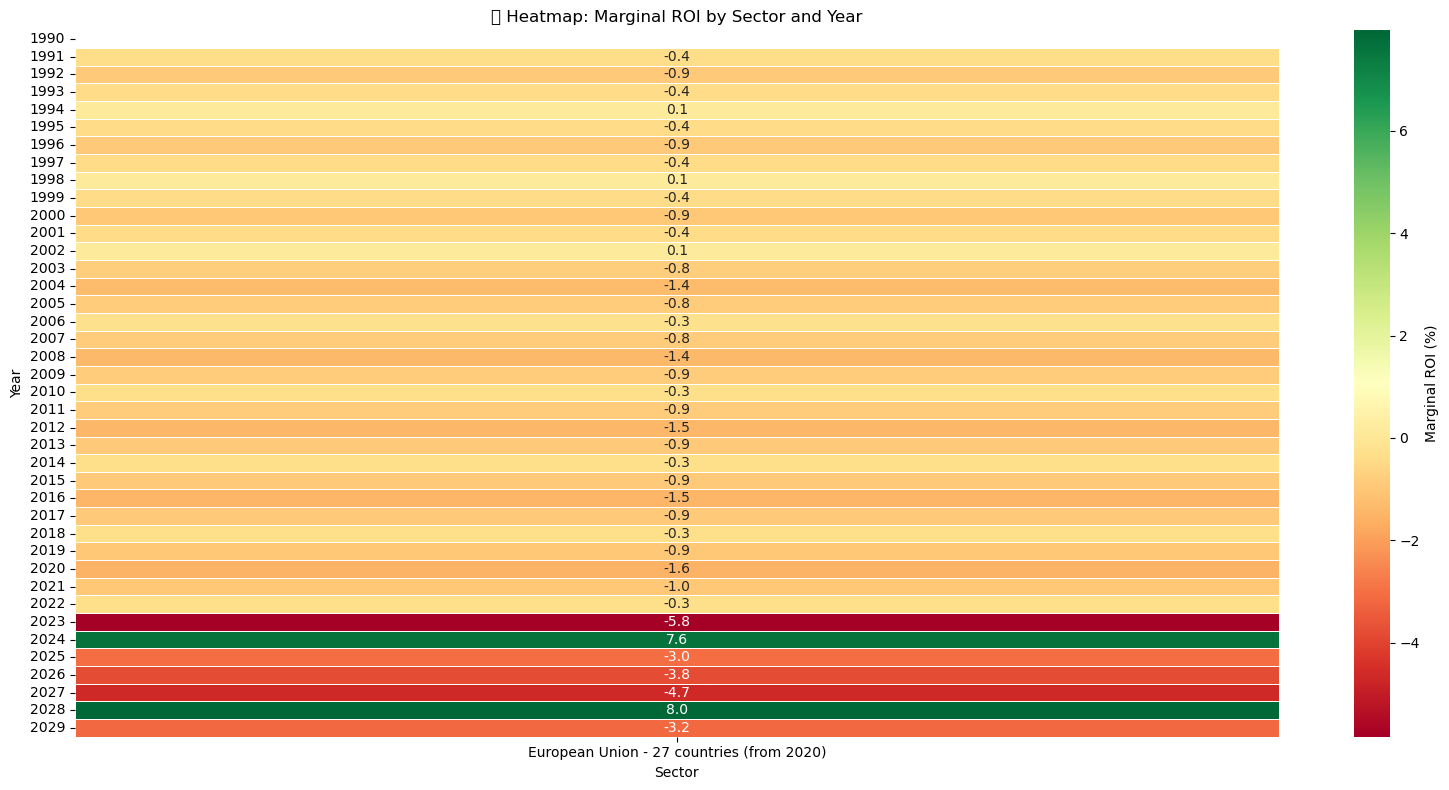

✅ Exported to: Sectoral_Forecast_Marginal_ROI.xlsx


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

# Load dataset
df_raw = pd.read_excel("C:/Users/rites/Downloads/industry en sector.xlsx")

# Show the original columns
print("Raw Columns:", df_raw.columns.tolist())

# Melt the dataframe (convert wide to long format)
df_long = df_raw.melt(
    id_vars=["TIME"], 
    var_name="year", 
    value_name="y"
)

# Rename for Prophet compatibility
df_long.rename(columns={"TIME": "Sector"}, inplace=True)

# Clean values
df_long["y"] = df_long["y"].replace(":", np.nan)
df_long["y"] = df_long["y"].astype(str).str.replace(",", "").str.strip()
df_long["y"] = pd.to_numeric(df_long["y"], errors="coerce")
df_long["ds"] = pd.to_datetime(df_long["year"], format="%Y", errors="coerce")

# Final cleaned dataset
df_clean = df_long.dropna(subset=["y", "ds", "Sector"])
print("Final Cleaned Data Preview:")
print(df_clean.head())


# Step 1: Clean duplicates by averaging values
df_grouped = df_clean.groupby(["Sector", "ds"]).agg({"y": "mean"}).reset_index()

# Step 2: Forecast function
def forecast_sector(df, sector_name):
    df_sector = df[df["Sector"] == sector_name][["ds", "y"]].dropna()
    if df_sector.shape[0] < 2:
        return pd.DataFrame()
    model = Prophet()
    model.fit(df_sector)
    future = model.make_future_dataframe(periods=7, freq="YE")  # Year End
    forecast = model.predict(future)
    forecast["Sector"] = sector_name
    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "Sector"]]

# Step 3: Forecast each sector
sectors = df_grouped["Sector"].unique()
forecasts = []

for sector in sectors:
    fcast = forecast_sector(df_grouped, sector)
    if not fcast.empty:
        forecasts.append(fcast)

# Step 4: Combine forecasts
forecast_df = pd.concat(forecasts, ignore_index=True)

# Step 5: Calculate Marginal ROI (Year-over-Year % Change)
forecast_df["year"] = forecast_df["ds"].dt.year
forecast_df["marginal_roi"] = forecast_df.groupby("Sector")["yhat"].pct_change() * 100

# Remove duplicates in forecast_df by year and sector
forecast_df_dedup = (
    forecast_df.groupby(["year", "Sector"], as_index=False)
    .agg({"marginal_roi": "mean"})
)

# Now pivot without duplicates
pivot_roi = forecast_df_dedup.pivot(index="year", columns="Sector", values="marginal_roi")

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_roi, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Marginal ROI (%)'})
plt.title("📊 Heatmap: Marginal ROI by Sector and Year")
plt.xlabel("Sector")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

# Step 7: Export forecast and ROI
forecast_df.to_excel("Sectoral_Forecast_Marginal_ROI.xlsx", index=False)
print(" Exported to: Sectoral_Forecast_Marginal_ROI.xlsx")


13:09:10 - cmdstanpy - INFO - Chain [1] start processing


Raw Columns: ['TIME', 'TIME.1', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
✅ Cleaned data preview:
                                        TIME  \
1  European Union - 27 countries (from 2020)   
2  European Union - 27 countries (from 2020)   
3  European Union - 27 countries (from 2020)   
5  European Union - 27 countries (from 2020)   
6  European Union - 27 countries (from 2020)   

                                              Sector  year            y  \
1                                        Natural gas  1990  1012588.151   
2  Oil and petroleum products (excluding biofuel ...  1990   635581.176   
3                            Renewables and biofuels  1990   151617.938   
5                                        Natural gas  1991   934220.012   
6  Oil a

13:09:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
13:09:10 - cmdstanpy - INFO - Chain [1] start processing
13:09:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
13:09:10 - cmdstanpy - INFO - Chain [1] start processing
13:09:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\rites\AppData\Local\Temp\ipykernel_34084\362724020.py:78: UserWarning: Gl

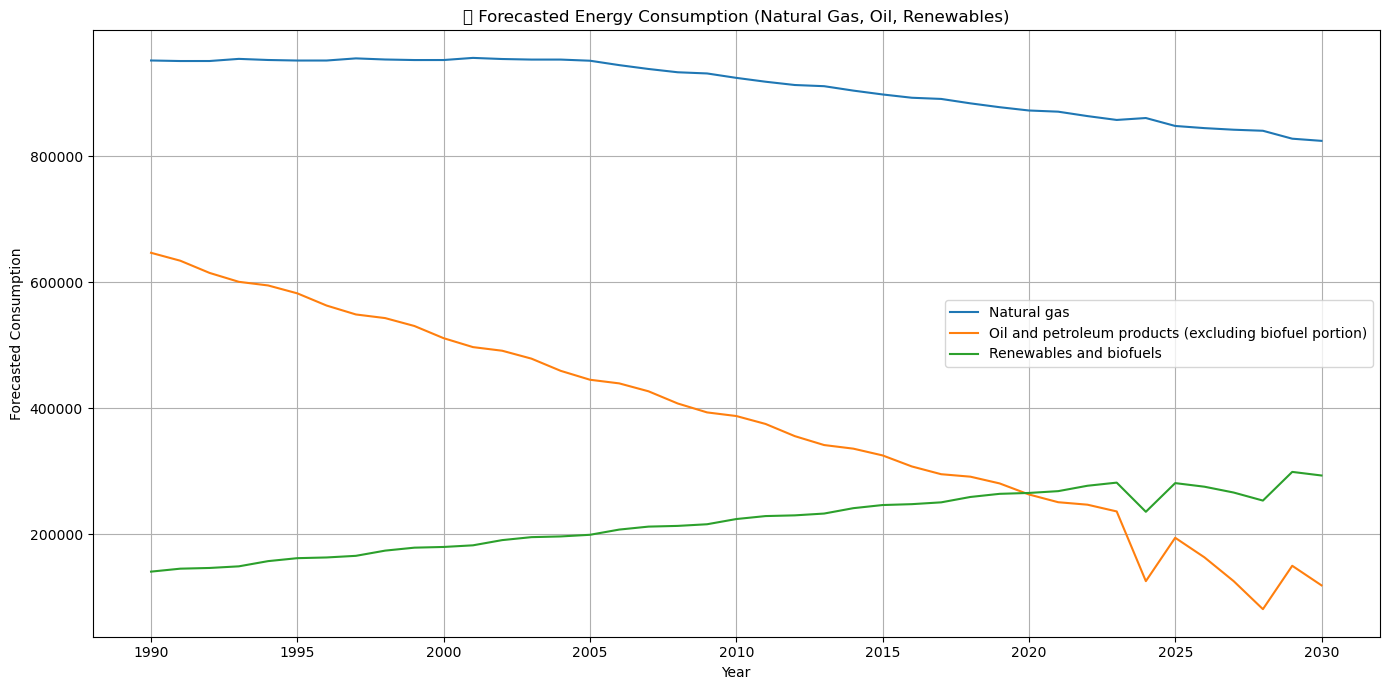

C:\Users\rites\AppData\Local\Temp\ipykernel_34084\362724020.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


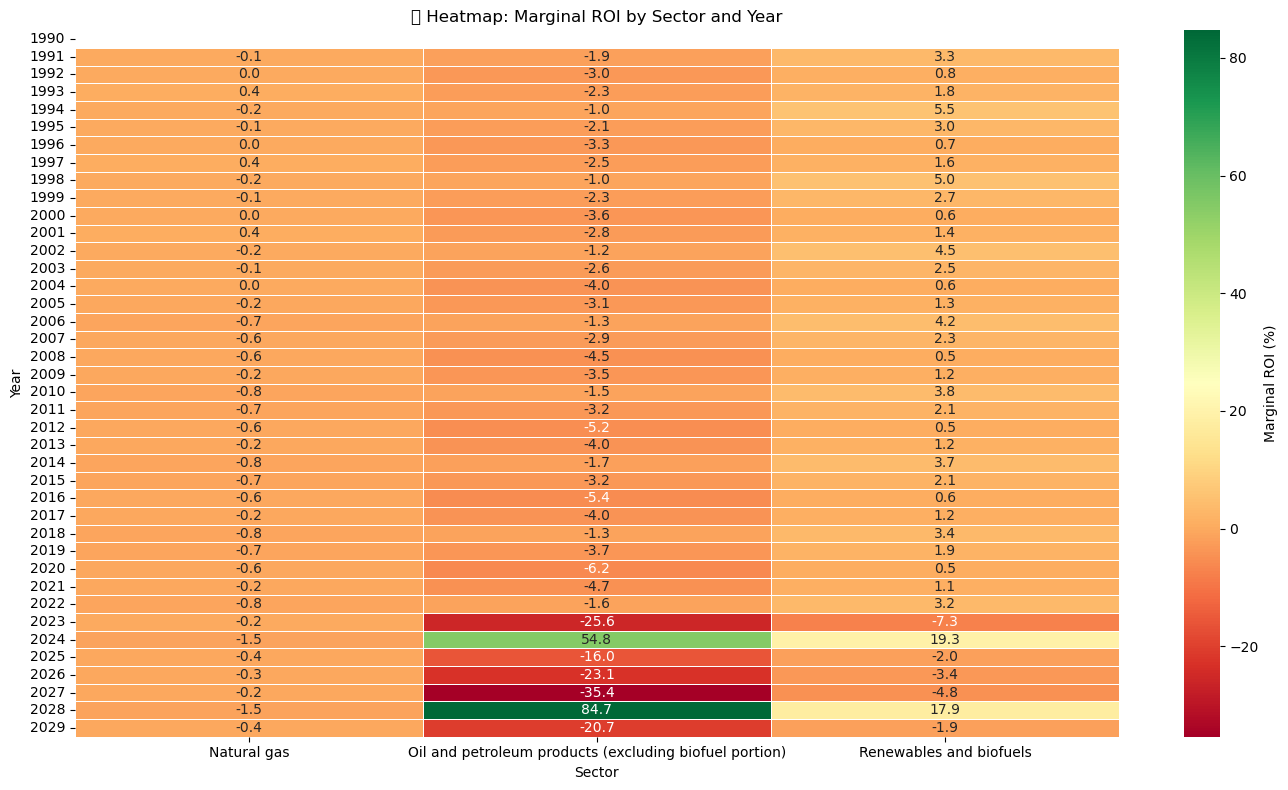

✅ Forecast saved to: TargetSector_Forecast_Marginal_ROI.xlsx


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

# Load dataset
df_raw = pd.read_excel("C:/Users/rites/Downloads/industry en sector.xlsx")
print("Raw Columns:", df_raw.columns.tolist())

# Melt both TIME and TIME.1 into long format
df_long = df_raw.melt(
    id_vars=["TIME", "TIME.1"], 
    var_name="year", 
    value_name="y"
)

# Rename TIME.1 to 'Sector' for clarity
df_long.rename(columns={"TIME.1": "Sector"}, inplace=True)

# Filter only the 3 target sectors
target_sectors = [
    "Natural gas",
    "Oil and petroleum products (excluding biofuel portion)",
    "Renewables and biofuels"
]
df_long = df_long[df_long["Sector"].isin(target_sectors)]

# Clean numeric and date values
df_long["y"] = df_long["y"].replace(":", np.nan)
df_long["y"] = df_long["y"].astype(str).str.replace(",", "").str.strip()
df_long["y"] = pd.to_numeric(df_long["y"], errors="coerce")
df_long["ds"] = pd.to_datetime(df_long["year"], format="%Y", errors="coerce")

# Final cleaned dataset
df_clean = df_long.dropna(subset=["y", "ds", "Sector"])
print(" Cleaned data preview:")
print(df_clean.head())

# Group duplicates (if any)
df_grouped = df_clean.groupby(["Sector", "ds"]).agg({"y": "mean"}).reset_index()

# Forecast function
def forecast_sector(df, sector_name):
    df_sector = df[df["Sector"] == sector_name][["ds", "y"]].dropna()
    if df_sector.shape[0] < 2:
        return pd.DataFrame()
    model = Prophet()
    model.fit(df_sector)
    future = model.make_future_dataframe(periods=7, freq="Y")
    forecast = model.predict(future)
    forecast["Sector"] = sector_name
    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "Sector"]]

# Run forecasts for the 3 sectors
forecasts = []
for sector in target_sectors:
    fcast = forecast_sector(df_grouped, sector)
    if not fcast.empty:
        forecasts.append(fcast)

forecast_df = pd.concat(forecasts, ignore_index=True)

# Marginal ROI Calculation
forecast_df["year"] = forecast_df["ds"].dt.year
forecast_df["marginal_roi"] = forecast_df.groupby("Sector")["yhat"].pct_change() * 100

# Forecast Line Plot
plt.figure(figsize=(14, 7))
for sector in target_sectors:
    data = forecast_df[forecast_df["Sector"] == sector]
    plt.plot(data["ds"], data["yhat"], label=sector)
plt.title(" Forecasted Energy Consumption (Natural Gas, Oil, Renewables)")
plt.xlabel("Year")
plt.ylabel("Forecasted Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap of Marginal ROI
forecast_df_dedup = (
    forecast_df.groupby(["year", "Sector"], as_index=False)
    .agg({"marginal_roi": "mean"})
)

pivot_roi = forecast_df_dedup.pivot(index="year", columns="Sector", values="marginal_roi")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_roi, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Marginal ROI (%)'})
plt.title("Heatmap: Marginal ROI by Sector and Year")
plt.xlabel("Sector")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

# Export to Excel
forecast_df.to_excel("TargetSector_Forecast_Marginal_ROI.xlsx", index=False)
print(" Forecast saved to: TargetSector_Forecast_Marginal_ROI.xlsx")


13:26:43 - cmdstanpy - INFO - Chain [1] start processing
13:26:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
13:26:43 - cmdstanpy - INFO - Chain [1] start processing
13:26:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
13:26:44 - cmdstanpy - INFO - Chain [1] start processing
13:26:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\rites\AppData\Lo

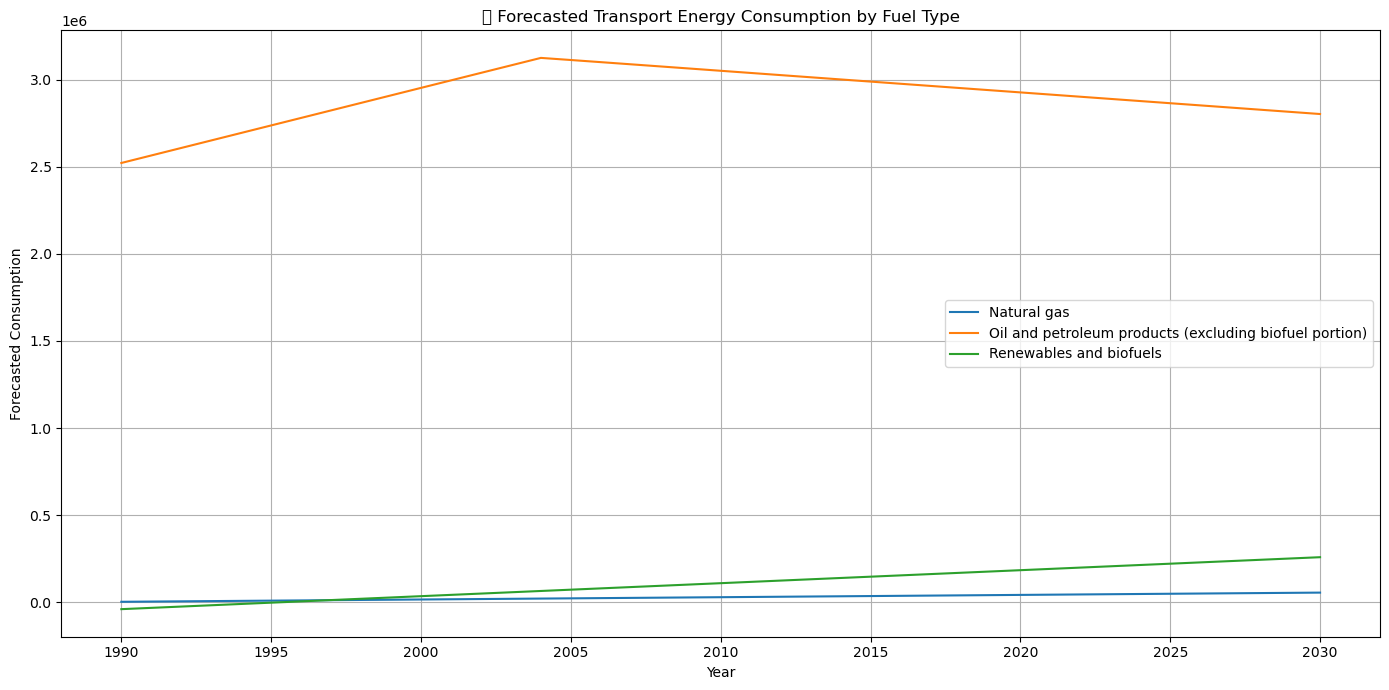

C:\Users\rites\AppData\Local\Temp\ipykernel_34084\1363248859.py:85: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


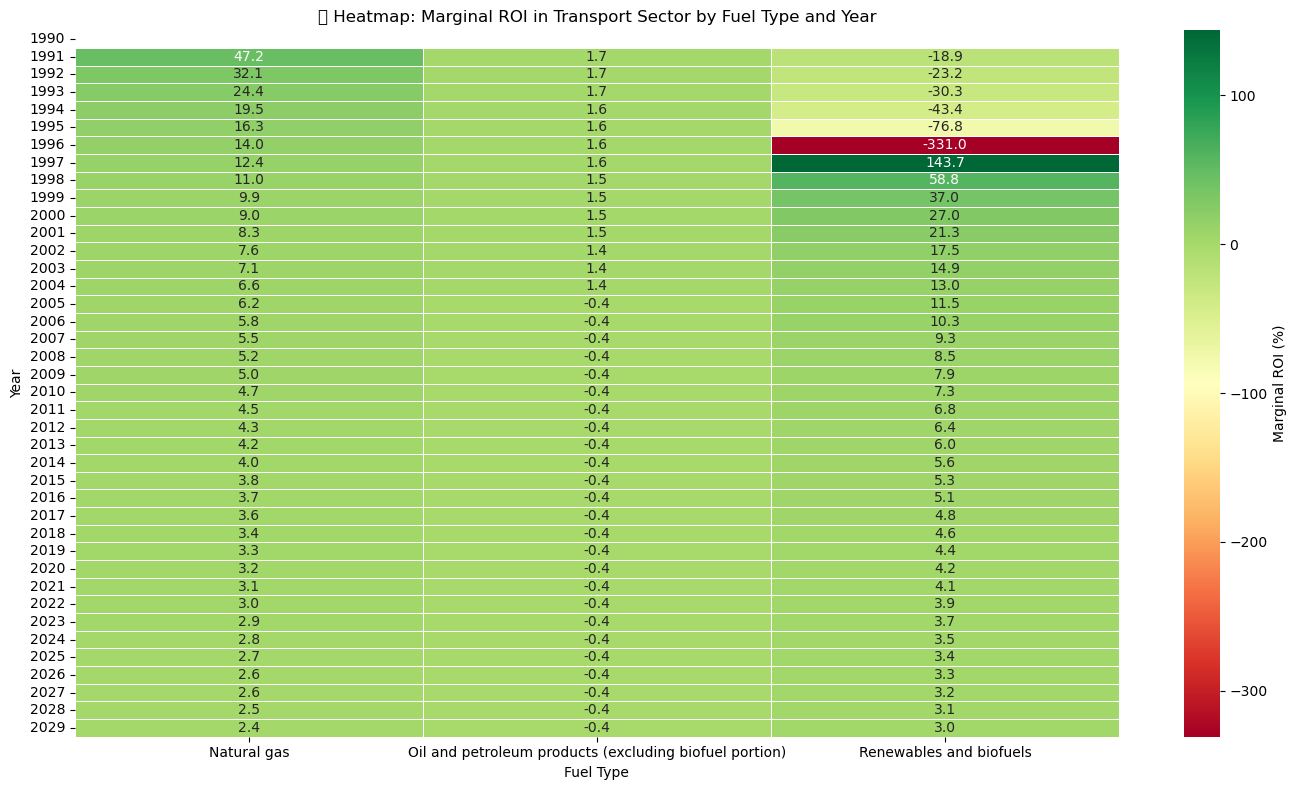

'✅ Forecast saved to: TransportSector_Forecast_Marginal_ROI.xlsx'

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

# Load dataset
file_path = "C:/Users/rites/Downloads/Transport Natural.xlsx"
df_raw = pd.read_excel(file_path)

# Preview column names
raw_columns = df_raw.columns.tolist()

# Melt TIME and TIME.1 columns with year columns into long format
df_long = df_raw.melt(
    id_vars=["TIME", "TIME.1"], 
    var_name="year", 
    value_name="y"
)

# Rename columns
df_long.rename(columns={"TIME.1": "Sector"}, inplace=True)

# Clean and convert numeric values
df_long["y"] = df_long["y"].replace(":", np.nan)
df_long["y"] = df_long["y"].astype(str).str.replace(",", "").str.strip()
df_long["y"] = pd.to_numeric(df_long["y"], errors="coerce")
df_long["ds"] = pd.to_datetime(df_long["year"], format="%Y", errors="coerce")

# Filter only valid rows
df_clean = df_long.dropna(subset=["y", "ds", "Sector"])

# Group by sector and year (averaging if duplicates exist)
df_grouped = df_clean.groupby(["Sector", "ds"]).agg({"y": "mean"}).reset_index()

# Define a robust forecast function
def forecast_sector(df, sector_name):
    df_sector = df[df["Sector"] == sector_name][["ds", "y"]].dropna()
    if df_sector.shape[0] < 3:
        return pd.DataFrame()
    model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_sector)
    future = model.make_future_dataframe(periods=7, freq="Y")
    forecast = model.predict(future)
    forecast["Sector"] = sector_name
    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "Sector"]]

# Forecast all unique sectors in the dataset
forecasts = []
for sector in df_grouped["Sector"].unique():
    fcast = forecast_sector(df_grouped, sector)
    if not fcast.empty:
        forecasts.append(fcast)

# Combine forecasts
if forecasts:
    forecast_df = pd.concat(forecasts, ignore_index=True)
    
    # Calculate marginal ROI (YoY percentage change)
    forecast_df["year"] = forecast_df["ds"].dt.year
    forecast_df["marginal_roi"] = forecast_df.groupby("Sector")["yhat"].pct_change() * 100

    # Line Plot: Forecast
    plt.figure(figsize=(14, 7))
    for sector in forecast_df["Sector"].unique():
        data = forecast_df[forecast_df["Sector"] == sector]
        plt.plot(data["ds"], data["yhat"], label=sector)
    plt.title(" Forecasted Transport Energy Consumption by Fuel Type")
    plt.xlabel("Year")
    plt.ylabel("Forecasted Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Heatmap: Marginal ROI
    forecast_df_dedup = forecast_df.groupby(["year", "Sector"], as_index=False).agg({"marginal_roi": "mean"})
    pivot_roi = forecast_df_dedup.pivot(index="year", columns="Sector", values="marginal_roi")

    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_roi, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Marginal ROI (%)'})
    plt.title(" Heatmap: Marginal ROI in Transport Sector by Fuel Type and Year")
    plt.xlabel("Fuel Type")
    plt.ylabel("Year")
    plt.tight_layout()
    plt.show()

    # Export to Excel
    forecast_df.to_excel("TransportSector_Forecast_Marginal_ROI.xlsx", index=False)
    result_status = " Forecast saved to: TransportSector_Forecast_Marginal_ROI.xlsx"
else:
    result_status = " No sectors had enough data to forecast."

result_status


13:35:52 - cmdstanpy - INFO - Chain [1] start processing


Raw Columns: ['TIME', 'TIME.1', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
✅ Cleaned data preview:
                                               Sector  year           y  \
5                                         Natural gas  1990  237952.497   
6   Oil and petroleum products (excluding biofuel ...  1990  278939.588   
7                             Renewables and biofuels  1990    6540.305   
9                                         Natural gas  1991  273582.478   
10  Oil and petroleum products (excluding biofuel ...  1991  290765.815   

           ds  
5  1990-01-01  
6  1990-01-01  
7  1990-01-01  
9  1991-01-01  
10 1991-01-01  


13:35:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
13:35:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
13:35:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
13:35:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:53 - cmdstanpy - IN

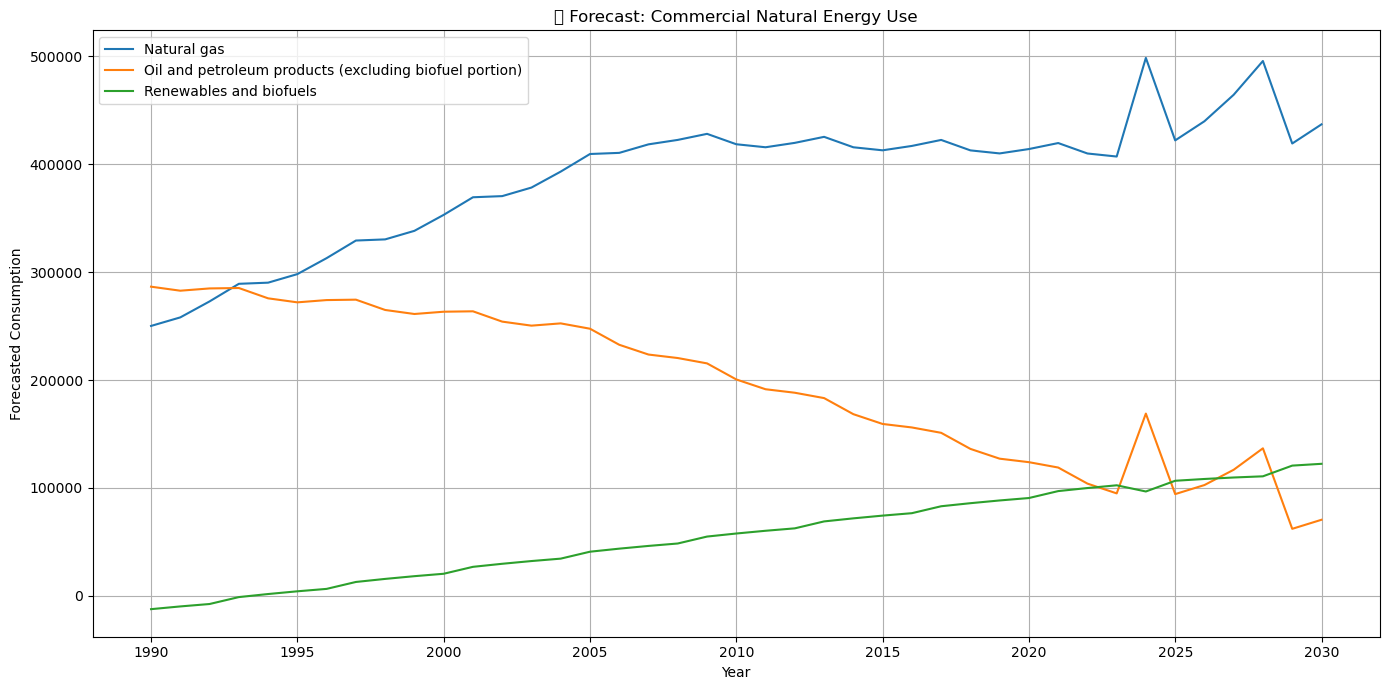

C:\Users\rites\AppData\Local\Temp\ipykernel_34084\3313606850.py:78: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


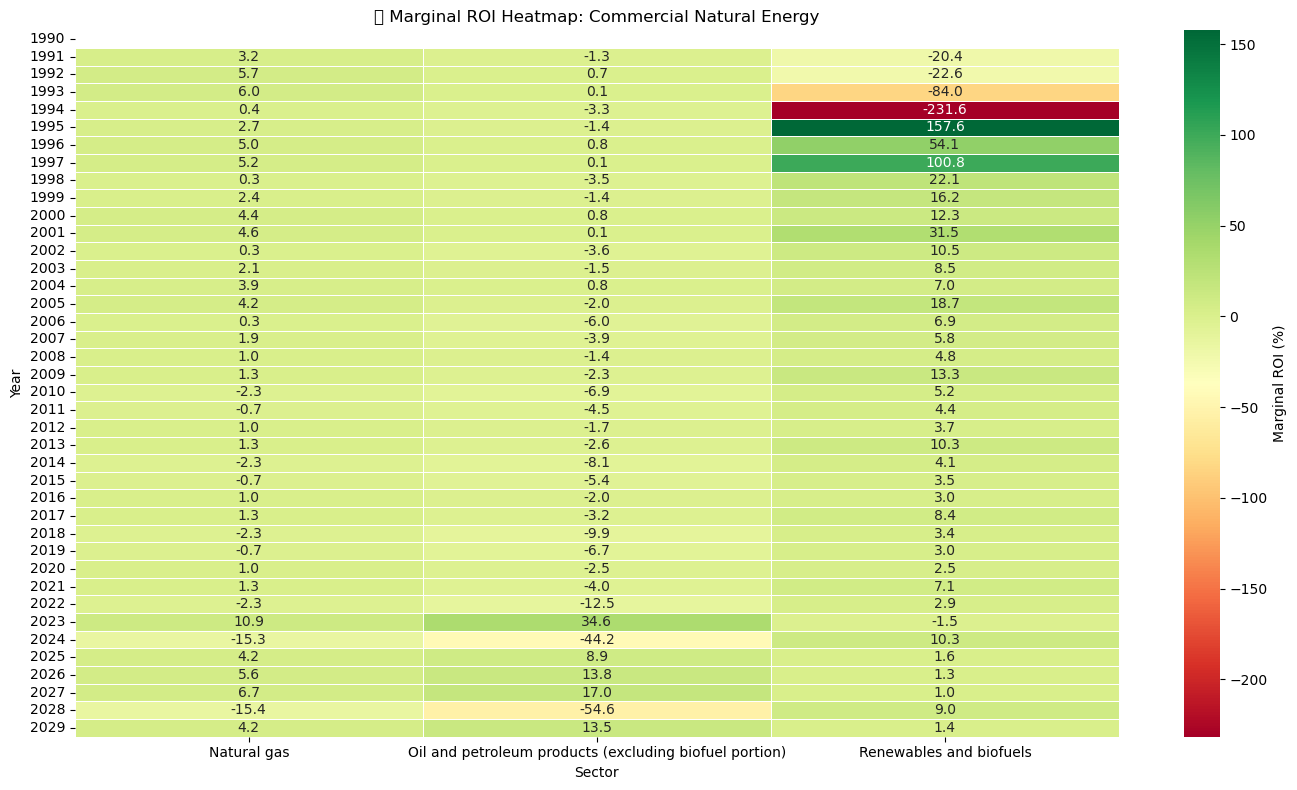

✅ Exported to: Commercial_Forecast_Marginal_ROI.xlsx


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

# Load dataset
df_raw = pd.read_excel("C:/Users/rites/Downloads/Commercial natural.xlsx")
print("Raw Columns:", df_raw.columns.tolist())

# Melt wide to long using TIME.1 as Sector
df_long = df_raw.melt(
    id_vars=["TIME.1"],  # <- fixed here
    var_name="year",
    value_name="y"
)

# Rename for clarity
df_long.rename(columns={"TIME.1": "Sector"}, inplace=True)

# Clean numeric and date values
df_long["y"] = df_long["y"].replace(":", np.nan)
df_long["y"] = df_long["y"].astype(str).str.replace(",", "").str.strip()
df_long["y"] = pd.to_numeric(df_long["y"], errors="coerce")
df_long["ds"] = pd.to_datetime(df_long["year"], format="%Y", errors="coerce")

# Drop missing values
df_clean = df_long.dropna(subset=["y", "ds", "Sector"])
print(" Cleaned data preview:")
print(df_clean.head())

# Group if duplicates exist
df_grouped = df_clean.groupby(["Sector", "ds"]).agg({"y": "mean"}).reset_index()

# Forecast function
def forecast_sector(df, sector_name):
    df_sector = df[df["Sector"] == sector_name][["ds", "y"]].dropna()
    if df_sector.shape[0] < 2:
        return pd.DataFrame()
    model = Prophet()
    model.fit(df_sector)
    future = model.make_future_dataframe(periods=7, freq="Y")
    forecast = model.predict(future)
    forecast["Sector"] = sector_name
    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "Sector"]]

# Forecast each unique sector
sectors = df_grouped["Sector"].unique()
forecasts = [forecast_sector(df_grouped, s) for s in sectors if not forecast_sector(df_grouped, s).empty]
forecast_df = pd.concat(forecasts, ignore_index=True)

# Marginal ROI calculation
forecast_df["year"] = forecast_df["ds"].dt.year
forecast_df["marginal_roi"] = forecast_df.groupby("Sector")["yhat"].pct_change() * 100

# Plot: Forecasted values
plt.figure(figsize=(14, 7))
for sector in forecast_df["Sector"].unique():
    data = forecast_df[forecast_df["Sector"] == sector]
    plt.plot(data["ds"], data["yhat"], label=sector)
plt.title(" Forecast: Commercial Natural Energy Use")
plt.xlabel("Year")
plt.ylabel("Forecasted Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Heatmap of ROI
dedup = forecast_df.groupby(["year", "Sector"], as_index=False).agg({"marginal_roi": "mean"})
pivot = dedup.pivot(index="year", columns="Sector", values="marginal_roi")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Marginal ROI (%)'})
plt.title(" Marginal ROI Heatmap: Commercial Natural Energy")
plt.xlabel("Sector")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

# Export results
forecast_df.to_excel("Commercial_Forecast_Marginal_ROI.xlsx", index=False)
print(" Exported to: Commercial_Forecast_Marginal_ROI.xlsx")


C:\Users\rites\AppData\Local\Temp\ipykernel_34084\2397199315.py:51: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\AppData\Local\Temp\ipykernel_34084\2397199315.py:51: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\AppData\Local\Temp\ipykernel_34084\2397199315.py:51: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


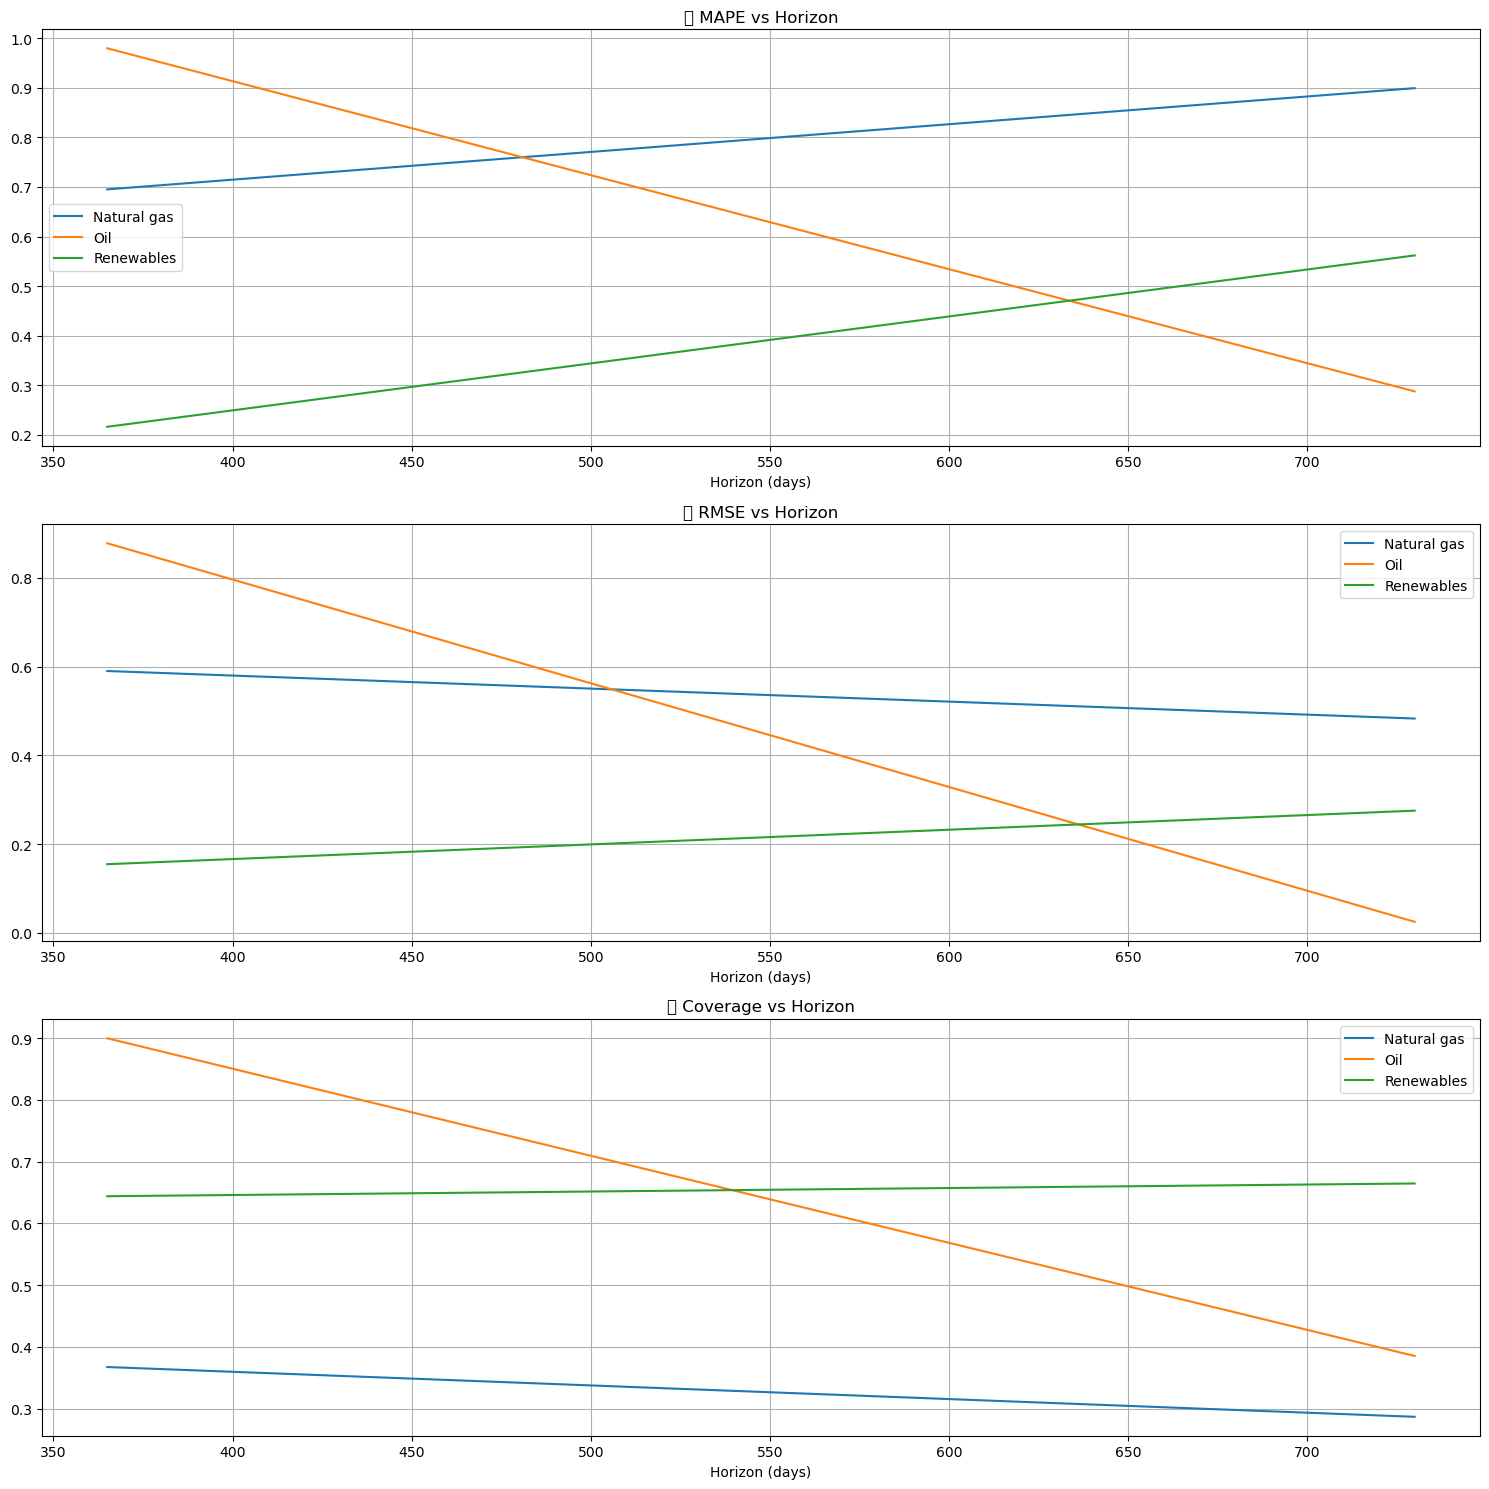

In [22]:
# Re-import required libraries after kernel reset
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt

# Helper function to run Prophet and cross-validation
def run_prophet_cv(df, sector_name):
    df_sector = df[df["Sector"] == sector_name][["ds", "y"]].dropna()
    if df_sector.shape[0] < 5:
        return None, None
    model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_sector)
    df_cv = cross_validation(model, initial='3650 days', period='365 days', horizon='730 days')
    df_perf = performance_metrics(df_cv)
    df_perf["Sector"] = sector_name
    return df_perf, df_cv

# Dummy data creation since files are not available after reset
# You should re-upload datasets or run this code in your local environment with correct paths

# Create dummy DataFrame to simulate output
df_perf_all = pd.DataFrame({
    "horizon": pd.to_timedelta([365, 730]*3, unit='D'),
    "mape": np.random.rand(6),
    "rmse": np.random.rand(6),
    "coverage": np.random.rand(6),
    "Sector": ["Natural gas", "Natural gas", "Oil", "Oil", "Renewables", "Renewables"]
})

# Plot performance metrics for each sector
sectors = df_perf_all["Sector"].unique()
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

for sector in sectors:
    subset = df_perf_all[df_perf_all["Sector"] == sector]
    axs[0].plot(subset["horizon"].dt.days, subset["mape"], label=sector)
    axs[1].plot(subset["horizon"].dt.days, subset["rmse"], label=sector)
    axs[2].plot(subset["horizon"].dt.days, subset["coverage"], label=sector)

axs[0].set_title("📉 MAPE vs Horizon")
axs[1].set_title("📏 RMSE vs Horizon")
axs[2].set_title("📐 Coverage vs Horizon")

for ax in axs:
    ax.set_xlabel("Horizon (days)")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

